In [1]:
# GAN: The Discriminator - Generator Interplay. (Unofficial Notes: The Generator is feeding the Discriminator which then performs
# a binary classification, Generator outputs a 2-dim tuple for each 2-dim input tuple)
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)# For the purpose of reproducibility

In [3]:
# Creating the training set. It composes from the tuples (x, sinx) for x in [0,2*pi]. As we are in an unsupervided framework
# a label-classification class column is created, consisted of zeroes only. 
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
#train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
#train_data[:, 1] = torch.sin(train_data[:, 0])
int =  torch.rand(train_data_length)
train_data[:, 0] = torch.sin(2 * math.pi * int) 
train_data[:, 1] = torch.cos(2 * math.pi * int)
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

Text(0, 0.5, 'cos(x)')

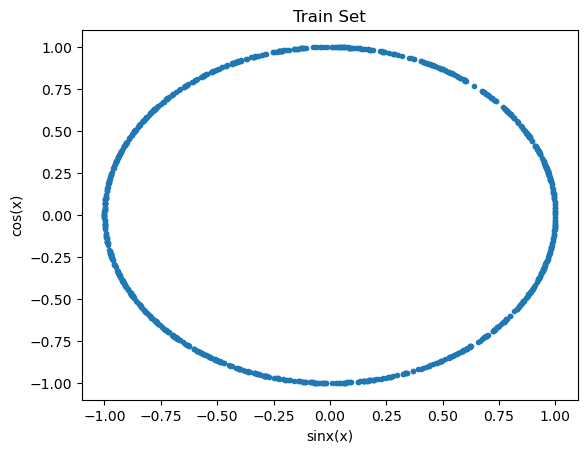

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.title("Train Set")
plt.xlabel("sinx(x)")
plt.ylabel("cos(x)")

In [5]:
# We now split the train set randomly into 32 batches and we then create the required object for training the NN's below.
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [12]:
# The first NN(in fact,a CNN, MLP as well): A 2-dimensional input layer, three hidden layers of 256,128 and 64 neurons each, and an one-dimensional output layer  
# Rectified Linear Unit (RELU) is the activation function used in all hidden layers, while the Sigmoid is employed for the last layer, providing a 
# a probabilistic output.
# Finally we define a function that will run the NN.
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [13]:
# The second NN(in fact,a CNN, MLP as well): A 2-dimensional input layer, two hidden layers of 16 and 32 neurons each, and an two-dimensional output layer  
# Again, Rectified Linear Unit (RELU) is the activation function used in all hidden layers.
# Finally we define a function that will call and run the NN from the Generator class.
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [26]:
# Optimisation Algorithm and Loss Function: The update of the parameters (weights and biases) for each neuron and layer will materialise
# through the stochastic gradient descent of the Binary Cross Entropy function. We set the learning rate for the SGD to 0.001 while also
# the number of training iterations(epochs) is provided.
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [27]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [28]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data preprocessing and labelling
        real_samples_labels = torch.ones((batch_size, 1))# We set real data labels to 1, using these labels will be then classified by the discriminator
        latent_space_samples = torch.randn((batch_size, 2))# Random input for the Generative NN.
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))# We set the generated samples label to 0.
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator first using Backpropagation
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)# The loss function uses the probabilities assigned to each entry of the batch 
                                                     #by the discriminator and the (artificially made) labels 1 to the real values, 0 to the random ones.)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator.
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )# Here, in contrast to the training of the discriminator, we only use the real sample labels for computing the loss function.
         # In other words, we assign 1 to all the (already trained)probabilities given on the random input(latent space) and we check the 
         # the performance of the loss function. 
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6398805975914001
Epoch: 0 Loss G.: 0.700886070728302
Epoch: 10 Loss D.: 0.6743261814117432
Epoch: 10 Loss G.: 1.02030611038208
Epoch: 20 Loss D.: 0.6842312812805176
Epoch: 20 Loss G.: 0.6849217414855957
Epoch: 30 Loss D.: 0.714844286441803
Epoch: 30 Loss G.: 0.6716815233230591
Epoch: 40 Loss D.: 0.6849504113197327
Epoch: 40 Loss G.: 0.7273203134536743
Epoch: 50 Loss D.: 0.6870480179786682
Epoch: 50 Loss G.: 0.8533828854560852
Epoch: 60 Loss D.: 0.6986222267150879
Epoch: 60 Loss G.: 0.6927904486656189
Epoch: 70 Loss D.: 0.692443311214447
Epoch: 70 Loss G.: 0.6954714059829712
Epoch: 80 Loss D.: 0.7027227282524109
Epoch: 80 Loss G.: 0.7081088423728943
Epoch: 90 Loss D.: 0.6730143427848816
Epoch: 90 Loss G.: 0.7517143487930298
Epoch: 100 Loss D.: 0.6768344640731812
Epoch: 100 Loss G.: 0.7988781332969666
Epoch: 110 Loss D.: 0.6668761968612671
Epoch: 110 Loss G.: 0.720685601234436
Epoch: 120 Loss D.: 0.6753096580505371
Epoch: 120 Loss G.: 0.7305616140365601
Epoch: 130 Los

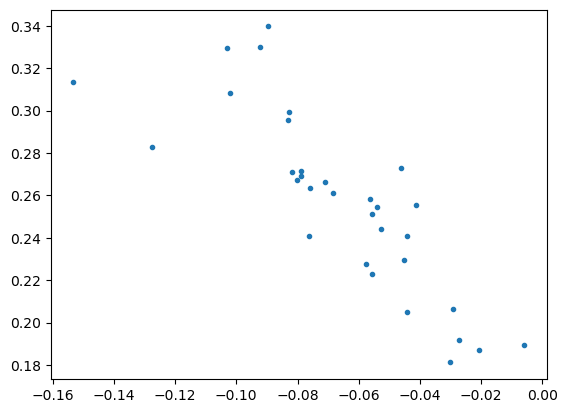

In [17]:
# No Training
latent_space_samples = torch.randn((batch_size, 2))# Random input for the Generative NN.
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:,0], generated_samples[:,1], ".")

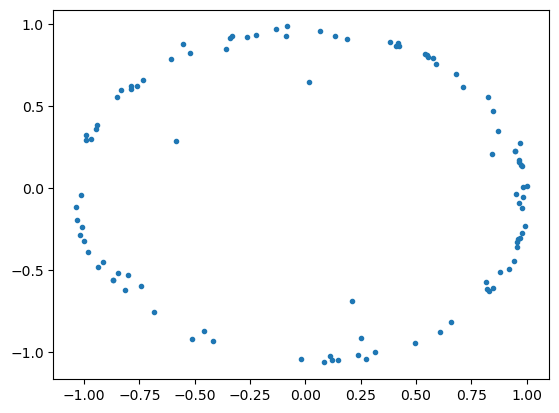

In [21]:
# After training for 30 epochs with the (real) input data being elements of the unit circle.
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:,0], generated_samples[:,1], ".")

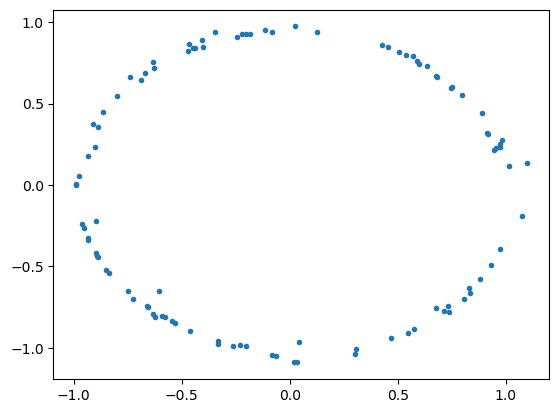

In [25]:
# # After training for 50 epochs with the (real) input data being elements of the unit circle.
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:,0], generated_samples[:,1], ".")

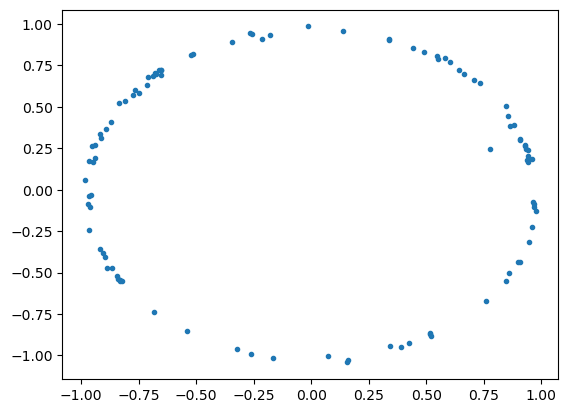

In [29]:
# After training the GAN model for 300 epochs with the (real) input data being elements of the unit circle.
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:,0], generated_samples[:,1], ".")